<a href="https://colab.research.google.com/github/NaimurRahmanR/temporal-shift-explainability-instability/blob/main/temporal_shift_explainability_instability_tabular_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import warnings
import numpy as np
import pandas as pd

from scipy import stats
from scipy.spatial.distance import jensenshannon
from scipy.stats import spearmanr

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from xgboost import XGBClassifier
import shap

warnings.filterwarnings("ignore")
np.random.seed(42)


In [16]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    ece = 0.0
    n = len(y_true)

    for b in range(n_bins):
        mask = bin_ids == b
        if np.sum(mask) == 0:
            continue
        acc = np.mean(y_true[mask])
        conf = np.mean(y_prob[mask])
        ece += (np.sum(mask) / n) * abs(acc - conf)

    return float(ece)


def brier_score(y_true, y_prob):
    return float(np.mean((y_true - y_prob) ** 2))


def bootstrap_cis(y_true, y_prob, n_boot=1000, ci=0.95, seed=42):

    rng = np.random.default_rng(seed)

    point = {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        "brier": brier_score(y_true, y_prob),
        "ece": expected_calibration_error(y_true, y_prob),
    }

    stats = {k: [] for k in point.keys()}
    n = len(y_true)

    for _ in range(n_boot):

        idx = rng.integers(0, n, size=n)

        yt = y_true[idx]
        yp = y_prob[idx]

        if len(np.unique(yt)) < 2:
            continue

        stats["roc_auc"].append(roc_auc_score(yt, yp))
        stats["pr_auc"].append(average_precision_score(yt, yp))
        stats["brier"].append(brier_score(yt, yp))
        stats["ece"].append(expected_calibration_error(yt, yp))

    alpha = (1 - ci) / 2
    lo = alpha * 100
    hi = (1 - alpha) * 100

    cis = {
        k: (float(np.percentile(v, lo)), float(np.percentile(v, hi)))
        for k, v in stats.items()
    }

    return point, cis


In [2]:
from google.colab import drive
drive.mount("/content/drive")

folder = "/content/drive/MyDrive/TSRL Paper"
csvs = [f for f in os.listdir(folder) if f.lower().endswith(".csv")]
csvs = sorted(csvs)

if len(csvs) == 0:
    raise FileNotFoundError("No CSV found in: " + folder)

PATH = os.path.join(folder, csvs[0])
print(PATH)

# Optional hard override:
# PATH = "/content/drive/MyDrive/TSRL Paper/LC_loans_granting_model_dataset.csv"
# print(PATH)


Mounted at /content/drive
/content/drive/MyDrive/TSRL Paper/LC_loans_granting_model_dataset.csv


In [3]:
TARGET = "Default"
TIME_COL = "issue_d"

df = pd.read_csv(PATH, low_memory=False)

try:
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], format="%b-%Y", errors="raise")
except Exception:
    df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors="coerce")

df = df.dropna(subset=[TIME_COL]).copy()

for c in ["title", "desc"]:
    if c in df.columns:
        df = df.drop(columns=[c])

df = df.sort_values(TIME_COL).reset_index(drop=True)

print("shape:", df.shape)
print("time range:", df[TIME_COL].min(), df[TIME_COL].max())
print("default rate:", float(df[TARGET].mean()))


shape: (1347681, 13)
time range: 2007-06-01 00:00:00 2018-12-01 00:00:00
default rate: 0.19978689318911522


In [4]:
def emp_length_to_years(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip().lower()
    if s in ["n/a", "na", "none"]:
        return np.nan
    if "<" in s:
        return 0.0
    if "10" in s:
        return 10.0
    digits = "".join(ch for ch in s if ch.isdigit())
    return float(digits) if digits else np.nan

drop_cols = [TARGET, TIME_COL]
if "id" in df.columns:
    drop_cols.append("id")

X = df.drop(columns=drop_cols).copy()
y = df[TARGET].astype(int)

if "emp_length_yrs" not in X.columns and "emp_length" in X.columns:
    X["emp_length_yrs"] = X["emp_length"].apply(emp_length_to_years)
    X = X.drop(columns=["emp_length"])

print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (1347681, 10)
y shape: (1347681,)


In [5]:
numeric_features = ["revenue", "dti_n", "loan_amnt", "fico_n", "emp_length_yrs"]
categorical_features = ["experience_c", "purpose", "home_ownership_n", "addr_state", "zip_code"]

num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median"))])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_features),
        ("cat", cat_pipe, categorical_features)
    ],
    remainder="drop"
)


In [6]:
def compute_ece(y_true, y_prob, n_bins=10):
    y_true = np.asarray(y_true).astype(int)
    y_prob = np.asarray(y_prob).astype(float)

    bins = np.linspace(0, 1, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        lo, hi = bins[i], bins[i + 1]
        if i < n_bins - 1:
            mask = (y_prob >= lo) & (y_prob < hi)
        else:
            mask = (y_prob >= lo) & (y_prob <= hi)

        if mask.sum() == 0:
            continue

        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / len(y_true)) * abs(acc - conf)

    return float(ece)

def report_metrics(y_true, y_prob, label):
    roc = roc_auc_score(y_true, y_prob)
    pr = average_precision_score(y_true, y_prob)
    brier = brier_score_loss(y_true, y_prob)
    ece = compute_ece(y_true, y_prob, n_bins=10)

    print(label)
    print("roc_auc:", roc)
    print("pr_auc:", pr)
    print("brier:", brier)
    print("ece:", ece)

    return {"roc_auc": roc, "pr_auc": pr, "brier": brier, "ece": ece}


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


random split
roc_auc: 0.670063787797596
pr_auc: 0.32453875683246913
brier: 0.15053916138096454
ece: 0.003955964289935445


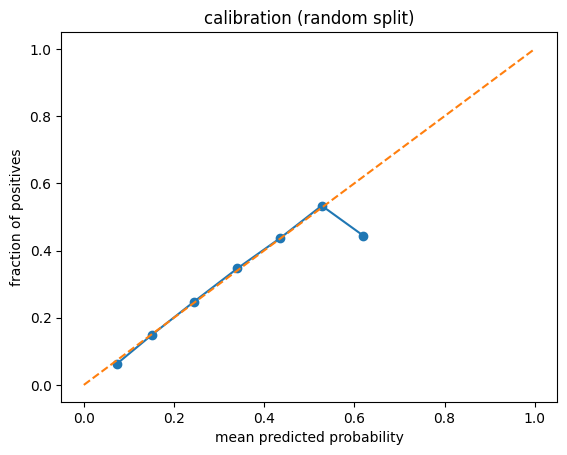

In [8]:
import xgboost as xgb
from dataclasses import dataclass

@dataclass
class XGBModelWrapper:
    preprocessor: object
    params: dict
    num_boost_round: int = 300
    booster: object = None
    feature_names_: object = None

    def fit(self, X_fit, y_fit):
        Xt = self.preprocessor.fit_transform(X_fit)
        self.feature_names_ = list(self.preprocessor.get_feature_names_out())
        dtrain = xgb.DMatrix(Xt, label=np.asarray(y_fit), feature_names=self.feature_names_)
        self.booster = xgb.train(self.params, dtrain, num_boost_round=self.num_boost_round)
        return self

    def predict_proba(self, X_pred):
        Xt = self.preprocessor.transform(X_pred)
        dtest = xgb.DMatrix(Xt, feature_names=self.feature_names_)
        p = self.booster.predict(dtest)
        p = np.clip(p, 1e-12, 1 - 1e-12)
        return np.column_stack([1 - p, p])

# Same hyperparameters as your paper
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 5,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 1.0,
    "tree_method": "hist",
    "seed": 42,
    "nthread": -1,
}

xgb_model = XGBModelWrapper(preprocessor=preprocessor, params=xgb_params, num_boost_round=300)

xgb_model.fit(X_train, y_train)
y_prob = xgb_model.predict_proba(X_test)[:, 1]
random_metrics = report_metrics(y_test, y_prob, "random split")

frac_pos, mean_pred = calibration_curve(y_test, y_prob, n_bins=10, strategy="uniform")
plt.figure()
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("calibration (random split)")
plt.xlabel("mean predicted probability")
plt.ylabel("fraction of positives")
plt.show()


temporal split (train<2017 test>=2017)
roc_auc: 0.684239037640783
pr_auc: 0.35735727327133165
brier: 0.15677533266648852
ece: 0.029407683897730432


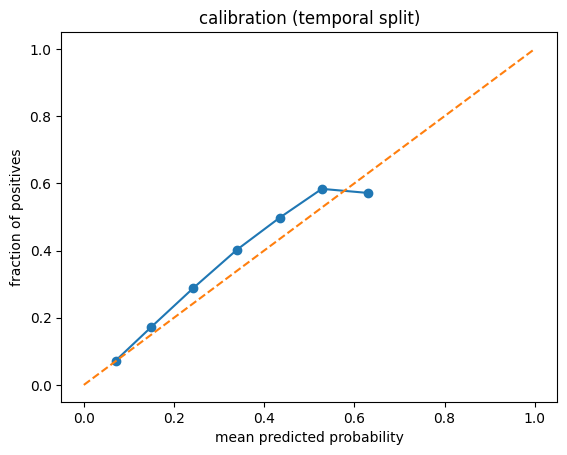

In [9]:
cutoff_date = pd.Timestamp("2017-01-01")

train_mask = df[TIME_COL] < cutoff_date
test_mask = df[TIME_COL] >= cutoff_date

X_train_temp = X.loc[train_mask].copy()
y_train_temp = y.loc[train_mask].copy()

X_test_temp = X.loc[test_mask].copy()
y_test_temp = y.loc[test_mask].copy()

xgb_model.fit(X_train_temp, y_train_temp)
y_prob_temp = xgb_model.predict_proba(X_test_temp)[:, 1]
temporal_metrics = report_metrics(y_test_temp, y_prob_temp, "temporal split (train<2017 test>=2017)")

frac_pos, mean_pred = calibration_curve(y_test_temp, y_prob_temp, n_bins=10, strategy="uniform")
plt.figure()
plt.plot(mean_pred, frac_pos, marker="o")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("calibration (temporal split)")
plt.xlabel("mean predicted probability")
plt.ylabel("fraction of positives")
plt.show()


In [10]:
def rolling_year_validation(df, X, y, start_year=2008, end_year=2018):
    rows = []
    for train_year in range(start_year, end_year):
        test_year = train_year + 1

        tr_mask = df[TIME_COL].dt.year <= train_year
        te_mask = df[TIME_COL].dt.year == test_year

        if tr_mask.sum() == 0 or te_mask.sum() == 0:
            continue

        Xtr = X.loc[tr_mask].copy()
        ytr = y.loc[tr_mask].copy()
        Xte = X.loc[te_mask].copy()
        yte = y.loc[te_mask].copy()

        rolling_model = Pipeline([
            ("preprocessor", preprocessor),
            ("classifier", LogisticRegression(max_iter=2000))
        ])

        rolling_model.fit(Xtr, ytr)
        prob = rolling_model.predict_proba(Xte)[:, 1]

        rows.append({
            "train_until_year": train_year,
            "test_year": test_year,
            "roc_auc": roc_auc_score(yte, prob),
            "pr_auc": average_precision_score(yte, prob),
            "brier": brier_score_loss(yte, prob),
            "ece": compute_ece(yte, prob, n_bins=10)
        })

    return pd.DataFrame(rows)

rolling_results_df = rolling_year_validation(df, X, y, start_year=2008, end_year=2018)
display(rolling_results_df.head())


,train_until_year,test_year,roc_auc,pr_auc,brier,ece
0,2008,2009,0.596824,0.200937,0.124569,0.065419
1,2009,2010,0.601992,0.188590,0.120179,0.024291
2,2010,2011,0.635375,0.232216,0.125216,0.012132
3,2011,2012,0.634391,0.240721,0.131754,0.009938
4,2012,2013,0.633154,0.229787,0.128078,0.010652


In [11]:
def categorical_distribution(s, top_k=100):
    s = s.astype(str).fillna("NA")
    top = s.value_counts().head(top_k).index
    s = s.where(s.isin(top), other="OTHER")
    return s.value_counts(normalize=True)

def psi_categorical(expected_dist, actual_dist):
    cats = sorted(set(expected_dist.index).union(set(actual_dist.index)))
    e = np.array([max(expected_dist.get(c, 0.0), 1e-6) for c in cats])
    a = np.array([max(actual_dist.get(c, 0.0), 1e-6) for c in cats])
    return float(np.sum((a - e) * np.log(a / e)))

def jsd_categorical(expected_dist, actual_dist):
    cats = sorted(set(expected_dist.index).union(set(actual_dist.index)))
    e = np.array([expected_dist.get(c, 0.0) for c in cats], dtype=float)
    a = np.array([actual_dist.get(c, 0.0) for c in cats], dtype=float)
    return float(jensenshannon(e, a, base=2.0))

train_vals = df.loc[train_mask]
test_vals = df.loc[test_mask]

cat_drift_results = []
for col in categorical_features:
    if col not in train_vals.columns or col not in test_vals.columns:
        continue

    e_dist = categorical_distribution(train_vals[col], top_k=100)
    a_dist = categorical_distribution(test_vals[col], top_k=100)

    cat_drift_results.append({
        "feature": col,
        "psi": psi_categorical(e_dist, a_dist),
        "jsd": jsd_categorical(e_dist, a_dist)
    })

categorical_drift_df = pd.DataFrame(cat_drift_results).sort_values("jsd", ascending=False)
display(categorical_drift_df)


,feature,psi,jsd
4,zip_code,0.227960,0.122513
1,purpose,0.048528,0.086298
3,addr_state,0.016086,0.052872
2,home_ownership_n,0.006299,0.033516
0,experience_c,0.000066,0.003337


In [12]:
def perturb_and_evaluate(model, X_base, feature, mode, value):
    Xp = X_base.copy()
    if mode == "add":
        Xp[feature] = Xp[feature] + value
    elif mode == "mult":
        Xp[feature] = Xp[feature] * value
    else:
        raise ValueError("mode must be 'add' or 'mult'")

    p0 = model.predict_proba(X_base)[:, 1]
    p1 = model.predict_proba(Xp)[:, 1]

    mean_shift = float(np.mean(np.abs(p1 - p0)))
    flip_rate = float(((p0 >= 0.5).astype(int) != (p1 >= 0.5).astype(int)).mean())
    return mean_shift, flip_rate

mask_2018 = (df[TIME_COL] >= "2018-01-01") & (df[TIME_COL] <= "2018-12-31")
train_mask_2018 = df[TIME_COL] < "2018-01-01"

X_2018 = X.loc[mask_2018].copy()
y_2018 = y.loc[mask_2018].copy()

X_train_pre2018 = X.loc[train_mask_2018].copy()
y_train_pre2018 = y.loc[train_mask_2018].copy()

xgb_model.fit(X_train_pre2018, y_train_pre2018)

robust_rows = []
for feat, mode, val, tag in [
    ("fico_n", "add", -10, "-10"),
    ("fico_n", "add",  10, "+10"),
    ("dti_n",  "add",  -2, "-2"),
    ("dti_n",  "add",   2, "+2"),
    ("revenue","mult",0.9, "-10%"),
    ("revenue","mult",1.1, "+10%")
]:
    shift, flip = perturb_and_evaluate(xgb_model, X_2018, feat, mode, val)
    robust_rows.append({"feature": feat, "perturbation": tag, "mean_abs_prob_shift": shift, "flip_rate@0.5": flip})

robustness_df = pd.DataFrame(robust_rows)
display(robustness_df)


,feature,perturbation,mean_abs_prob_shift,flip_rate@0.5
0,fico_n,-10,0.018523,0.002938
1,fico_n,+10,0.016124,0.001300
2,dti_n,-2,0.006126,0.000748
3,dti_n,+2,0.006798,0.000783
4,revenue,-10%,0.006440,0.000730
5,revenue,+10%,0.005877,0.000463


In [13]:
def _to_dense(M):
    return M.toarray() if hasattr(M, "toarray") else M

def shap_importance_from_wrapper(xgb_model, X_sample, max_rows=10000, seed=42):
    if len(X_sample) > max_rows:
        Xs = X_sample.sample(max_rows, random_state=seed)
    else:
        Xs = X_sample.copy()

    Xt = _to_dense(xgb_model.preprocessor.transform(Xs))
    feature_names = xgb_model.feature_names_

    explainer = shap.TreeExplainer(xgb_model.booster)
    shap_vals = explainer.shap_values(Xt)

    if isinstance(shap_vals, list):
        shap_vals = shap_vals[0]

    mean_abs = np.mean(np.abs(shap_vals), axis=0)
    imp = pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
    imp = imp.sort_values("mean_abs_shap", ascending=False).reset_index(drop=True)
    return imp

def spearman_rank_corr(imp_a, imp_b, top_k=50):
    a = imp_a.head(top_k).copy()
    b = imp_b.head(top_k).copy()

    feats = sorted(set(a["feature"]).union(set(b["feature"])))
    ra = {f: i for i, f in enumerate(a["feature"].tolist())}
    rb = {f: i for i, f in enumerate(b["feature"].tolist())}

    xa = np.array([ra.get(f, top_k) for f in feats], dtype=float)
    xb = np.array([rb.get(f, top_k) for f in feats], dtype=float)

    corr, _ = spearmanr(xa, xb)
    return float(corr)

xgb_model.fit(X_train, y_train)
shap_random = shap_importance_from_wrapper(xgb_model, X_test, max_rows=10000, seed=42)

xgb_model.fit(X_train_temp, y_train_temp)
shap_temporal = shap_importance_from_wrapper(xgb_model, X_test_temp, max_rows=10000, seed=43)

corr_rand_temp = spearman_rank_corr(shap_random, shap_temporal, top_k=50)
print("spearman random vs temporal:", corr_rand_temp)

def fit_until_year_and_shap(year):
    tr_mask = df[TIME_COL].dt.year < year
    te_mask = df[TIME_COL].dt.year == year

    Xtr = X.loc[tr_mask].copy()
    ytr = y.loc[tr_mask].copy()
    Xte = X.loc[te_mask].copy()

    xgb_model.fit(Xtr, ytr)
    return shap_importance_from_wrapper(xgb_model, Xte, max_rows=10000, seed=year)

shap_2012 = fit_until_year_and_shap(2012)
shap_2015 = fit_until_year_and_shap(2015)
shap_2018 = fit_until_year_and_shap(2018)

shap_stability_df = pd.DataFrame([
    {"comparison": "2012 vs 2015", "time_gap_years": 3, "spearman_corr": spearman_rank_corr(shap_2012, shap_2015, top_k=50)},
    {"comparison": "2015 vs 2018", "time_gap_years": 3, "spearman_corr": spearman_rank_corr(shap_2015, shap_2018, top_k=50)},
    {"comparison": "2012 vs 2018", "time_gap_years": 6, "spearman_corr": spearman_rank_corr(shap_2012, shap_2018, top_k=50)},
])

display(shap_stability_df)


spearman random vs temporal: 0.4516222760290557


,comparison,time_gap_years,spearman_corr
0,2012 vs 2015,3,-0.373235
1,2015 vs 2018,3,-0.063154
2,2012 vs 2018,6,-0.483965


In [14]:
import os
import matplotlib.pyplot as plt

results_dir = os.path.join(folder, "results")
os.makedirs(results_dir, exist_ok=True)

print("saving to:", results_dir)

# ---------- Tables ----------

if "rolling_results_df" in globals():
    rolling_results_df.to_csv(os.path.join(results_dir, "rolling_performance.csv"), index=False)

if "numeric_drift_df" in globals():
    numeric_drift_df.to_csv(os.path.join(results_dir, "numeric_drift.csv"), index=False)

if "categorical_drift_df" in globals():
    categorical_drift_df.to_csv(os.path.join(results_dir, "categorical_drift.csv"), index=False)

if "robustness_df" in globals():
    robustness_df.to_csv(os.path.join(results_dir, "robustness_perturbation.csv"), index=False)

if "shap_stability_df" in globals():
    shap_stability_df.to_csv(os.path.join(results_dir, "shap_stability.csv"), index=False)

# ---------- SHAP feature tables ----------

if "shap_random" in globals():
    shap_random.head(100).to_csv(os.path.join(results_dir, "shap_random_top100.csv"), index=False)

if "shap_temporal" in globals():
    shap_temporal.head(100).to_csv(os.path.join(results_dir, "shap_temporal_top100.csv"), index=False)

if "shap_2012" in globals():
    shap_2012.head(100).to_csv(os.path.join(results_dir, "shap_2012_top100.csv"), index=False)

if "shap_2015" in globals():
    shap_2015.head(100).to_csv(os.path.join(results_dir, "shap_2015_top100.csv"), index=False)

if "shap_2018" in globals():
    shap_2018.head(100).to_csv(os.path.join(results_dir, "shap_2018_top100.csv"), index=False)

# ---------- Save Calibration Plots ----------

def save_calibration_plot(y_true, y_prob, filename):
    from sklearn.calibration import calibration_curve
    frac_pos, mean_pred = calibration_curve(y_true, y_prob, n_bins=10, strategy="uniform")
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("mean predicted probability")
    plt.ylabel("fraction of positives")
    plt.title("calibration curve")
    plt.tight_layout()
    plt.savefig(os.path.join(results_dir, filename), dpi=300)
    plt.close()

if "y_test" in globals() and "y_prob" in globals():
    save_calibration_plot(y_test, y_prob, "calibration_random.png")

if "y_test_temp" in globals() and "y_prob_temp" in globals():
    save_calibration_plot(y_test_temp, y_prob_temp, "calibration_temporal.png")

print("all results exported successfully.")


saving to: /content/drive/MyDrive/TSRL Paper/results
all results exported successfully.


In [20]:
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    bin_ids = np.digitize(y_prob, bins) - 1
    bin_ids = np.clip(bin_ids, 0, n_bins - 1)

    ece = 0.0
    n = len(y_true)
    for b in range(n_bins):
        mask = bin_ids == b
        if mask.sum() == 0:
            continue
        acc = y_true[mask].mean()
        conf = y_prob[mask].mean()
        ece += (mask.sum() / n) * abs(acc - conf)
    return float(ece)

def brier_score(y_true, y_prob):
    return float(np.mean((y_true - y_prob) ** 2))

def bootstrap_cis(y_true, y_prob, n_boot=1000, ci=0.95, seed=42):
    # ✅ convert pandas Series/Index to numpy arrays (positional)
    y_true = np.asarray(getattr(y_true, "to_numpy", lambda: y_true)())
    y_prob = np.asarray(getattr(y_prob, "to_numpy", lambda: y_prob)())

    rng = np.random.default_rng(seed)

    point = {
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
        "brier": brier_score(y_true, y_prob),
        "ece": expected_calibration_error(y_true, y_prob),
    }

    stats = {k: [] for k in point.keys()}
    n = len(y_true)

    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        yp = y_prob[idx]

        if np.unique(yt).size < 2:
            continue

        stats["roc_auc"].append(roc_auc_score(yt, yp))
        stats["pr_auc"].append(average_precision_score(yt, yp))
        stats["brier"].append(brier_score(yt, yp))
        stats["ece"].append(expected_calibration_error(yt, yp))

    alpha = (1 - ci) / 2
    lo = alpha * 100
    hi = (1 - alpha) * 100

    cis = {k: (float(np.percentile(v, lo)), float(np.percentile(v, hi))) for k, v in stats.items()}
    return point, cis


In [21]:
# Random split CI
point_r, ci_r = bootstrap_cis(y_test, y_prob, n_boot=1000, ci=0.95, seed=42)

# Temporal split CI
point_t, ci_t = bootstrap_cis(y_test_temp, y_prob_temp, n_boot=1000, ci=0.95, seed=42)


In [22]:
def fmt(x):
    return f"{x:.3f}"

def cell(point, ci, k):
    lo, hi = ci[k]
    return f"{fmt(point[k])} [{fmt(lo)}, {fmt(hi)}]"

rows = [("ROC AUC","roc_auc"), ("PR AUC","pr_auc"), ("Brier Score","brier"), ("ECE","ece")]

print("Metric | Random Split | Temporal Split")
print("---|---|---")
for name, k in rows:
    print(f"{name} | {cell(point_r, ci_r, k)} | {cell(point_t, ci_t, k)}")


Metric | Random Split | Temporal Split
---|---|---
ROC AUC | 0.670 [0.668, 0.672] | 0.684 [0.682, 0.687]
PR AUC | 0.325 [0.321, 0.328] | 0.357 [0.353, 0.361]
Brier Score | 0.151 [0.150, 0.151] | 0.157 [0.156, 0.158]
ECE | 0.004 [0.003, 0.006] | 0.029 [0.028, 0.031]


In [23]:
import numpy as np

# === PUT YOUR REAL VALUES HERE ===

# From Table 1
roc_random = 0.670
roc_temporal = 0.684

ece_random = 0.004
ece_temporal = 0.029

# Drift (use your main reported value – example JSD max)
drift_random = 0.0      # random split baseline
drift_temporal = 0.072  # your highest JSD

# Robustness (use flip rate for FICO -10)
robust_random = 0.0
robust_temporal = 0.0046

# SHAP stability (use largest temporal gap or main comparison)
shap_random = 1.0
shap_temporal = 0.42


# === NORMALISATION FUNCTIONS ===

def scale_positive(x, xmin, xmax):
    return (x - xmin) / (xmax - xmin)

def scale_negative(x, xmin, xmax):
    return 1 - (x - xmin) / (xmax - xmin)


# Discrimination
disc_r = scale_positive(roc_random, 0.5, 0.7)
disc_t = scale_positive(roc_temporal, 0.5, 0.7)

# Calibration
cal_r = scale_negative(ece_random, 0.0, 0.05)
cal_t = scale_negative(ece_temporal, 0.0, 0.05)

# Drift
drift_r = 1.0
drift_t = scale_negative(drift_temporal, 0.0, 0.10)

# Robustness
rob_r = 1.0
rob_t = scale_negative(robust_temporal, 0.0, 0.01)

# Explainability
shap_r = 1.0
shap_t = shap_temporal


random_values = [disc_r, cal_r, drift_r, rob_r, shap_r]
temporal_values = [disc_t, cal_t, drift_t, rob_t, shap_t]


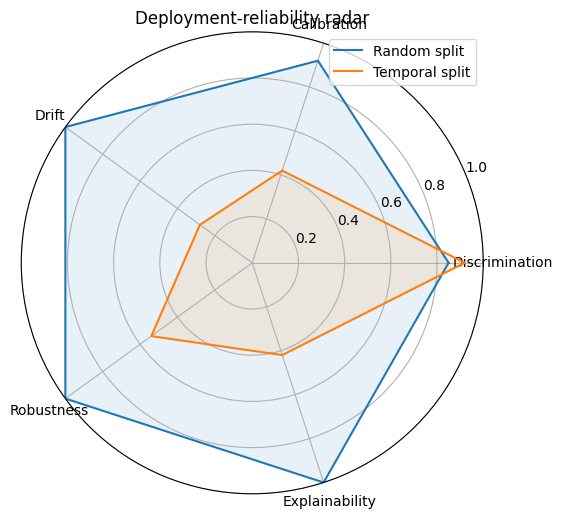

In [27]:
import matplotlib.pyplot as plt

labels = [
    "Discrimination",
    "Calibration",
    "Drift",
    "Robustness",
    "Explainability"
]

angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False)
angles = np.concatenate([angles, [angles[0]]])

random_plot = np.concatenate([random_values, [random_values[0]]])
temporal_plot = np.concatenate([temporal_values, [temporal_values[0]]])

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

ax.plot(angles, random_plot, label="Random split")
ax.fill(angles, random_plot, alpha=0.1)

ax.plot(angles, temporal_plot, label="Temporal split")
ax.fill(angles, temporal_plot, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)

ax.set_ylim(0,1)
ax.set_title("Deployment-reliability radar")

plt.legend(loc="upper right")
plt.show()
